In [1]:
# define a pytensor Op for our likelihood function
from pl_temp_fit import Exp_data_utils, fit_Pl_exp_EMCEE

import numpy as np
import os
import matplotlib.pyplot as plt
import datetime
import os
os.chdir('/rds/general/user/ma11115/home/pl_temp_fit/') 

['experiemental_data/blends/PM6Y61_1PL.csv', 'experiemental_data/blends/PM6Y61_1EL.csv']
experiemental_data/blends/PM6Y61_1PL.csv


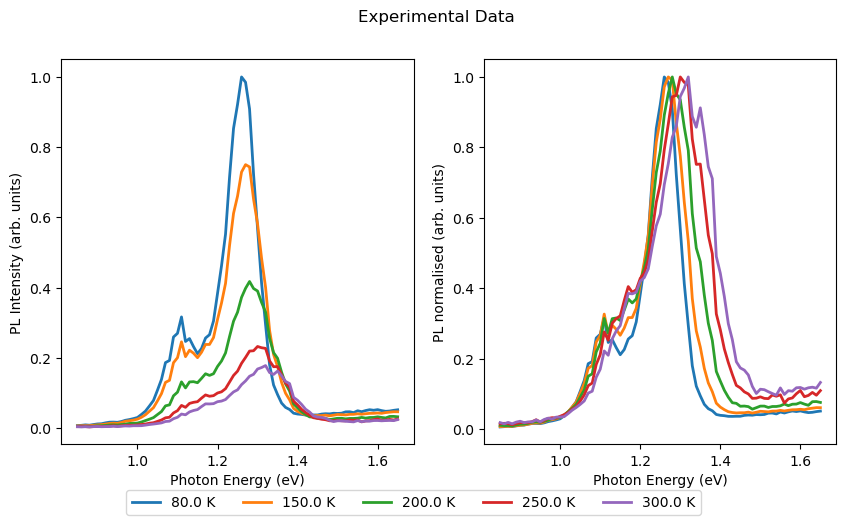

In [3]:
# import the data and plot them
import importlib
import glob
csv_files = glob.glob('experiemental_data/blends/*.csv')
print(csv_files)
csv_name=csv_files[0]#3 for y6, 18 for ITIC,12 for L8BO
print(csv_name)
Exp_data, temperature_list, hws = Exp_data_utils.read_data(csv_name)
fig,ax = Exp_data_utils.plot_PL_data(Exp_data, temperature_list, hws,title="Experimental Data")

In [4]:
#initialise parameters for the model
number_free_parameters , sigma, Temp_std_err, hws_std_err, relative_intensity_std_error = 5, 0.005, 10, 0.005, 0.05
num_samples = 1000
num_tune = 1000

model_config = {
            "number_free_parameters": number_free_parameters,
            "sigma": sigma,
            "Temp_std_err": Temp_std_err,
            "hws_std_err": hws_std_err,
            "relative_intensity_std_error": relative_intensity_std_error,
        }
X = {'temperature_list':temperature_list, 'hws':hws}
date=datetime.datetime.now().strftime("%Y_%m_%d")
# generate the data
save_folder = (
    f"fit_experimental_emcee/{date}/{csv_name.split('/')[-1]}/num_samples="
    + " sigma=" + str(sigma)
    + " temperature_list=" + str(len(temperature_list))
    + " number_free_parameters=" + str(number_free_parameters)
    + " Temp_std_err="+str(Temp_std_err)
    + " hws_std_err="+str(hws_std_err)
    + " relative_intensity_std_error="+str(relative_intensity_std_error)
)
os.makedirs(save_folder, exist_ok=True)

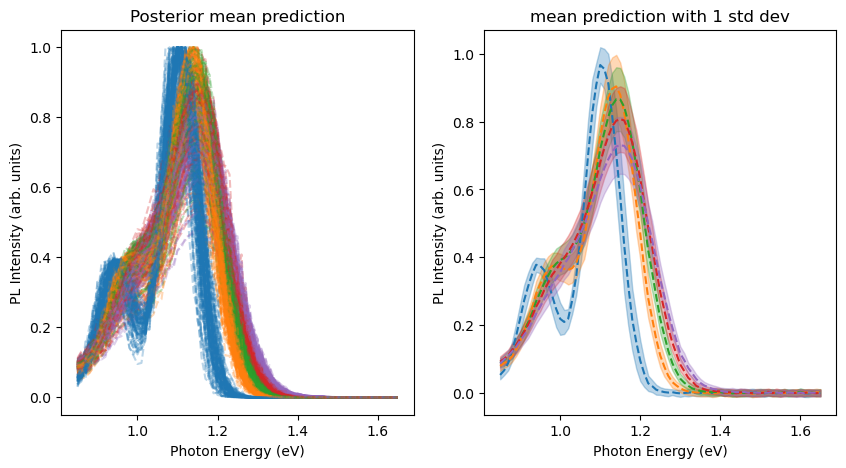

In [5]:
import importlib
importlib.reload(fit_Pl_exp_EMCEE)
#get covariance matrix for the experimental data
init_params = [hws[np.argmax(Exp_data[:,0])], 0.02, 0.1, 0.1, 0.16]
co_var_mat = fit_Pl_exp_EMCEE.plot_generated_data( temperature_list, hws, save_folder, model_config, savefig=True,true_parameters=init_params)

(<Figure size 2000x500 with 5 Axes>,
 array([<Axes: title={'center': 'temperature=80.0 K'}, xlabel='Photon Energy (eV)', ylabel='PL Intensity (arb. units)'>,
        <Axes: title={'center': 'temperature=150.0 K'}, xlabel='Photon Energy (eV)', ylabel='PL Intensity (arb. units)'>,
        <Axes: title={'center': 'temperature=200.0 K'}, xlabel='Photon Energy (eV)', ylabel='PL Intensity (arb. units)'>,
        <Axes: title={'center': 'temperature=250.0 K'}, xlabel='Photon Energy (eV)', ylabel='PL Intensity (arb. units)'>,
        <Axes: title={'center': 'temperature=300.0 K'}, xlabel='Photon Energy (eV)', ylabel='PL Intensity (arb. units)'>],
       dtype=object))

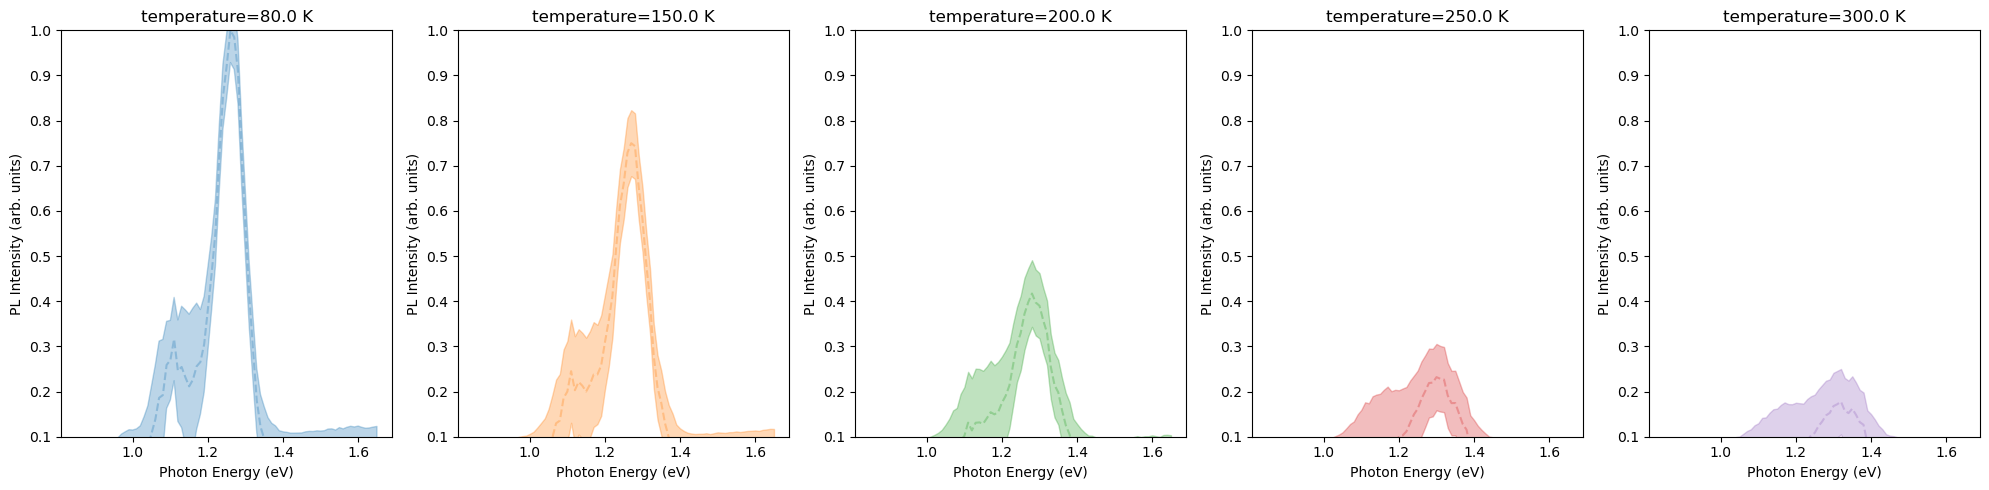

In [6]:
# add noise to the data and plot it
variance_data = co_var_mat.diagonal().reshape(hws.shape[0],-1).copy()#variance.copy()
Exp_data_utils.plot_PL_data_with_variance(Exp_data, temperature_list, hws, variance_data, save_folder)


In [7]:
# get maximum likelihood estimate
soln = fit_Pl_exp_EMCEE.get_maximum_likelihood_estimate(Exp_data, co_var_mat,X,save_folder,init_params=init_params)

[1.37159386e+00 1.00000000e-03 7.87203363e-02 1.12738205e-01
 1.59916771e-01]
Maximum likelihood estimates:
  E = 1.372
  sigma = 0.001
  LI = 0.079
  L0 = 0.113
  H0 = 0.160
Maximum log likelihood: 45.51906864229093


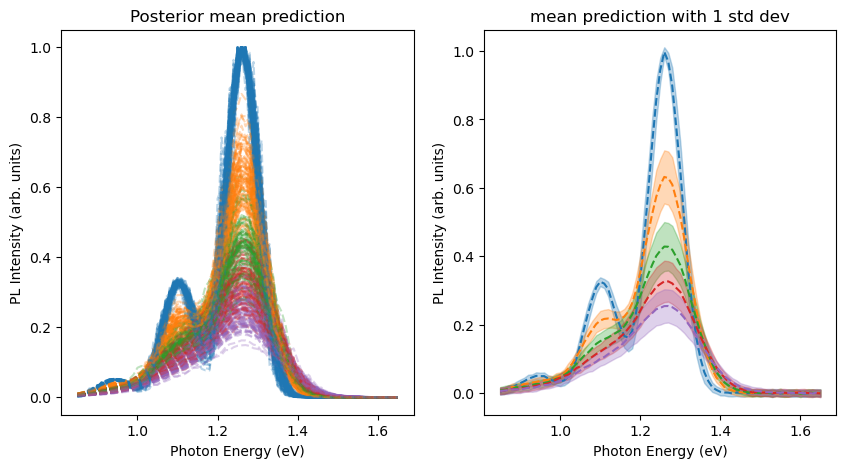

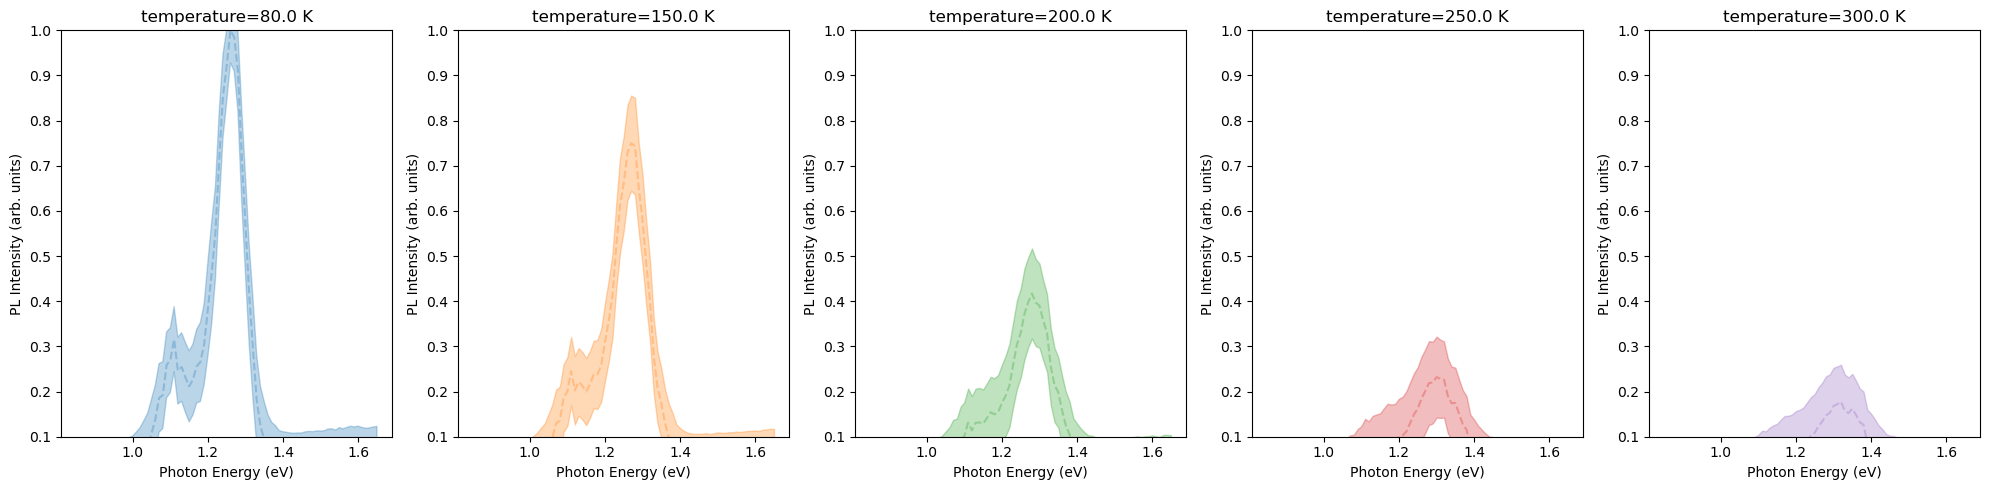

In [8]:
# add noise to the data and plot it now with the fitted parameters
co_var_mat = fit_Pl_exp_EMCEE.plot_generated_data( temperature_list, hws, save_folder, model_config, savefig=False, true_parameters=soln.x)
variance_data = co_var_mat.diagonal().reshape(hws.shape[0],-1).copy()#variance.copy()
fig,ax = Exp_data_utils.plot_PL_data_with_variance(Exp_data, temperature_list, hws, variance_data, save_folder)

In [28]:
import importlib
importlib.reload(fit_Pl_exp_EMCEE)

sampler = fit_Pl_exp_EMCEE.run_sampler_single(save_folder, soln, Exp_data, co_var_mat, X,nsteps =10)

Initial size: 0


  0%|          | 0/10 [00:00<?, ?it/s]/rds/general/user/ma11115/home/anaconda3/envs/pymc_env/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10/10 [00:32<00:00,  3.21s/it]

single process took 35.3 seconds


In [30]:
# submit to HPC
import glob
csv_files = glob.glob('experiemental_data/*.csv')
csv_name=csv_files[0]#3 for y6, 18 for ITIC,12 for L8BO
sh_name = f"Run_EMCEE_PM6Y6_12.sh"
script="#!/bin/bash \n"+\
    "#PBS -l walltime=07:59:01 \n"+\
    "#PBS -l select=1:ncpus=32:mem=50gb:avx=true \n"+\
    " \n"+\
    "cd /rds/general/user/ma11115/home/pl_temp_fit/ \n"+\
    "module load anaconda3/personal \n"+ \
    "source activate pymc_env     \n"+\
    f"python src/pl_temp_fit/fit_Pl_exp_EMCEE.py --test_number 2 --data_file {csv_name} \n"#${'PBS_ARRAY_INDEX'}#f"#PBS -J 1-{16} \n"+\
#print(script) 
with open(f'HPC_bash_script/{sh_name}', 'wb') as f:
    f.write( bytes(script, 'utf-8'))  

!qsub  -e ./cache -o ./cache HPC_bash_script/Run_EMCEE_PM6Y6_12.sh #submit to HPC

/bin/bash: which: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `which'
/bin/bash: module: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `module'
/bin/bash: scl: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `scl'
/bin/bash: ml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `ml'
/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'
/bin/sh: scl: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `scl'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
sh: which: line 1: syntax error: unexpected end of file


In [54]:
saver_folder

'fit_experimental_emcee/2024_01_24/Y6_SWrecipe.csv/ sigma=0.01 temperature_list=7 number_free_parameters=5 Temp_std_err=2 hws_std_err=0.05 relative_intensity_std_error=0.01'

In [105]:
for x in name.split(' '):
    print(x)


sigma=0.01
temperature_list=7
number_free_parameters=5
Temp_std_err=2
hws_std_err=0.05
relative_intensity_std_error=0.01


In [122]:
name

'num_samples= sigma=0.005 temperature_list=7 number_free_parameters=5 Temp_std_err=10 hws_std_err=0.005 relative_intensity_std_error=0.05'

In [193]:
# analyse results
import importlib
import glob
csv_files = glob.glob('experiemental_data/*.csv')
csv_names=[csv_files[x] for x in [3,18,12]]#3 for y6, 18 for ITIC,12 for L8BO

list_params = []
for csv_name in csv_names:
    folder = glob.glob(f"fit_experimental_emcee/*/{csv_name.split('/')[-1]}/*")
    for f in folder:
        name = f.split('/')[-1]
        print(name)
        if 'sampler.h5' in os.listdir(f):
            
            saver_folder = f
            params_dict = {}
            for x in name.split(' '):
                if '=' in x:
                    try:
                        params_dict[x.split('=')[0]]=int(x.split('=')[1])
                    except:
                        print(x)
            # put results into a dataframe
        # reload sampler from file
            try:
                filename = f + "/sampler.h5"

                reader = fit_Pl_exp_EMCEE.hDFBackend_2(filename, name="multi_core")
                distribution = reader.get_chain(discard=1, thin=5, flat=True)
                true_parameters=list(np.mean(distribution,axis=0))
                params_dict['mean'] = [f"{x:.3f}" for x in true_parameters]      
                params_dict['saved_folder'] = f        
                params_dict['num_iteration'] = reader.iteration  
                params_dict['exp_data'] = csv_name.split('/')[-1]   
                log_prob = reader.get_log_prob(discard=2, thin=1, flat=True)  
                params_dict['max_log_prob'] = np.max(log_prob)
                params_dict['csv_position'] = csv_names.index(csv_name)
                list_params.append(params_dict)                      
            except:
                print('error')
                print(f)
                print('error')
                pass


import pandas as pd
df = pd.DataFrame.from_records(list_params)
df


 sigma=0.01 temperature_list=7 number_free_parameters=5 Temp_std_err=2 hws_std_err=0.05 relative_intensity_std_error=0.01
sigma=0.01
hws_std_err=0.05
relative_intensity_std_error=0.01
num_samples= sigma=0.005 temperature_list=7 number_free_parameters=5 Temp_std_err=10 hws_std_err=0.005 relative_intensity_std_error=0.05
num_samples=
sigma=0.005
hws_std_err=0.005
relative_intensity_std_error=0.05
error
fit_experimental_emcee/2024_01_24/Y6_SWrecipe.csv/num_samples= sigma=0.005 temperature_list=7 number_free_parameters=5 Temp_std_err=10 hws_std_err=0.005 relative_intensity_std_error=0.05
error
num_samples=1000 num_tune=1000 sigma=0.005 temperature_list=7 number_free_parameters=5 Temp_std_err=10 hws_std_err=0.005 relative_intensity_std_error=0.05
 sigma=0.01 temperature_list=7 number_free_parameters=5 Temp_std_err=2 hws_std_err=0.05 relative_intensity_std_error=0.01
sigma=0.01
hws_std_err=0.05
relative_intensity_std_error=0.01
num_samples= sigma=0.005 temperature_list=7 number_free_paramete

,temperature_list,number_free_parameters,Temp_std_err,mean,saved_folder,num_iteration,exp_data,max_log_prob,csv_position
0,7,5,2,"[1.359, 0.013, 0.058, 0.091, 0.164]",fit_experimental_emcee/2024_01_24/Y6_SWrecipe....,10000,Y6_SWrecipe.csv,-11.672517,0
1,7,5,2,"[1.902, 0.003, 0.193, 0.041, 0.192]",fit_experimental_emcee/2024_01_24/ITIC.csv/ si...,157,ITIC.csv,-106.280932,1
2,7,5,2,"[1.650, 0.004, 0.109, 0.141, 0.174]",fit_experimental_emcee/2024_01_25/ITIC.csv/ si...,10000,ITIC.csv,-26.262534,1
3,4,5,2,"[1.413, 0.021, 0.053, 0.077, 0.178]",fit_experimental_emcee/2024_01_24/L8BO-noannea...,10000,L8BO-noanneal.csv,-10.696348,2


In [135]:
# reload sampler from file
index = 0
filename = df['saved_folder'][index] + "/sampler.h5"
csv_name = csv_names[df['csv_position'][index]]
reader = fit_Pl_exp_EMCEE.hDFBackend_2(filename, name="multi_core")
print("Initial size: {0}".format(reader.iteration))
#new_sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(Exp_data, co_var_mat, temperature_list, hws),backend=new_backend)
#new_sampler.run_mcmc(new_sampler.get_chain()[0, :, :], 10, progress=True)
#print("Final size: {0}".format(new_backend.iteration))

Initial size: 10000


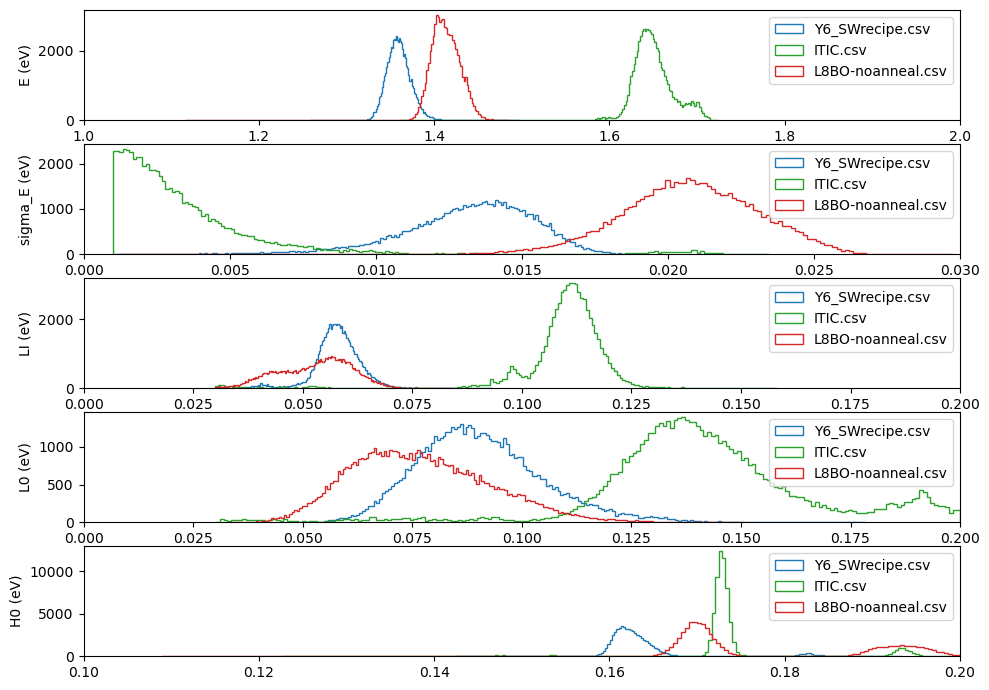

In [166]:
fig, axes = plt.subplots(5, figsize=(10, 7))
labels = ["E (eV)" , "sigma_E (eV)", "LI (eV)", "L0 (eV)", "H0 (eV)"]

for index in [0,2,3]:

    filename = df['saved_folder'][index] + "/sampler.h5"
    csv_name = csv_names[df['csv_position'][index]]
    reader = fit_Pl_exp_EMCEE.hDFBackend_2(filename, name="multi_core")
    distribution = reader.get_chain(discard=1, thin=5, flat=True)

    axes_xlim = [[1,2],[0,0.03],[0,0.2],[0,0.2],[0.1,0.2]]
    for i in range(ndim):
        ax = axes[i]
        ax.hist(distribution[:, i], 200, color=f"C{index}", histtype="step",label=csv_name.split('/')[-1])
        #ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.set_xlim(axes_xlim[i])
        ax.legend(loc="upper right")
fig.tight_layout(h_pad=0.0)

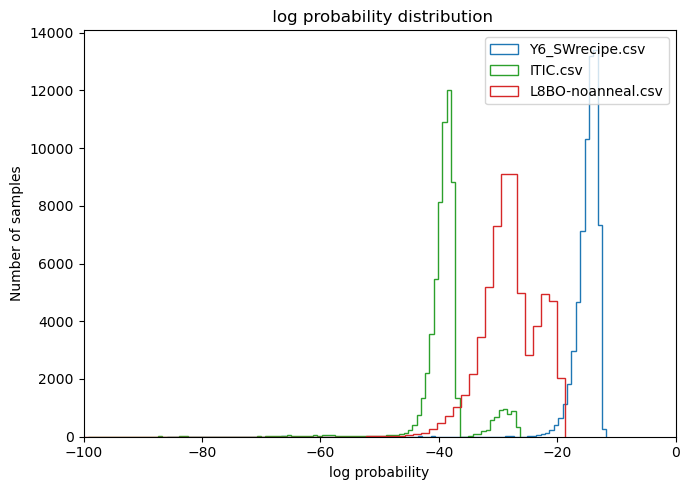

In [164]:
fig, axes = plt.subplots(1, figsize=(7, 5))
labels = ["E (eV)" , "sigma_E (eV)", "LI (eV)", "L0 (eV)", "H0 (eV)"]

for index in [0,2,3]:

    filename = df['saved_folder'][index] + "/sampler.h5"
    csv_name = csv_names[df['csv_position'][index]]
    reader = fit_Pl_exp_EMCEE.hDFBackend_2(filename, name="multi_core")

    axes_xlim = [[1,2],[0,0.03],[0,0.2],[0,0.2],[0.1,0.2]]
    flat_samples = reader.get_log_prob(discard=2, thin=5, flat=True)
    axes.hist(flat_samples[flat_samples>-1e2]*7/df['temperature_list'][index], 100, color=f"C{index}", histtype="step",label=csv_name.split('/')[-1])
axes.set_xlabel("log probability")
axes.set_ylabel("Number of samples")
axes.set_xlim(-100,0)
axes.set_title(' log probability distribution')
axes.legend(loc="upper right")

fig.tight_layout(h_pad=0.0)

experiemental_data/Y6_SWrecipe.csv
experiemental_data/ITIC.csv
experiemental_data/L8BO-noanneal.csv


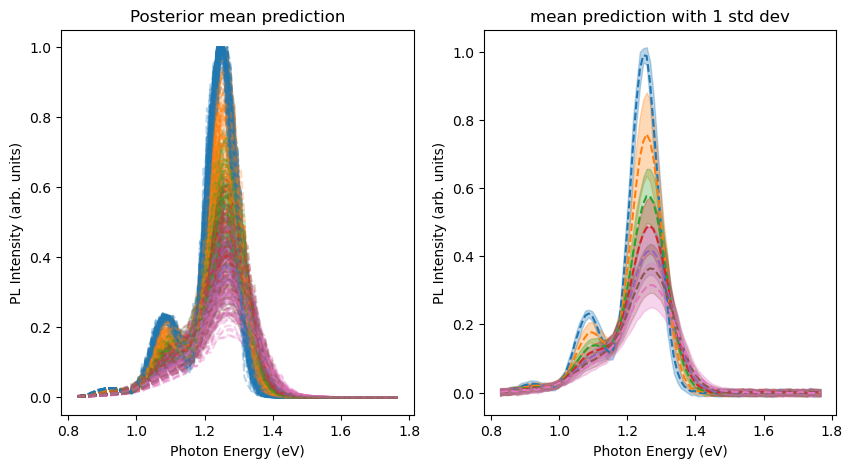

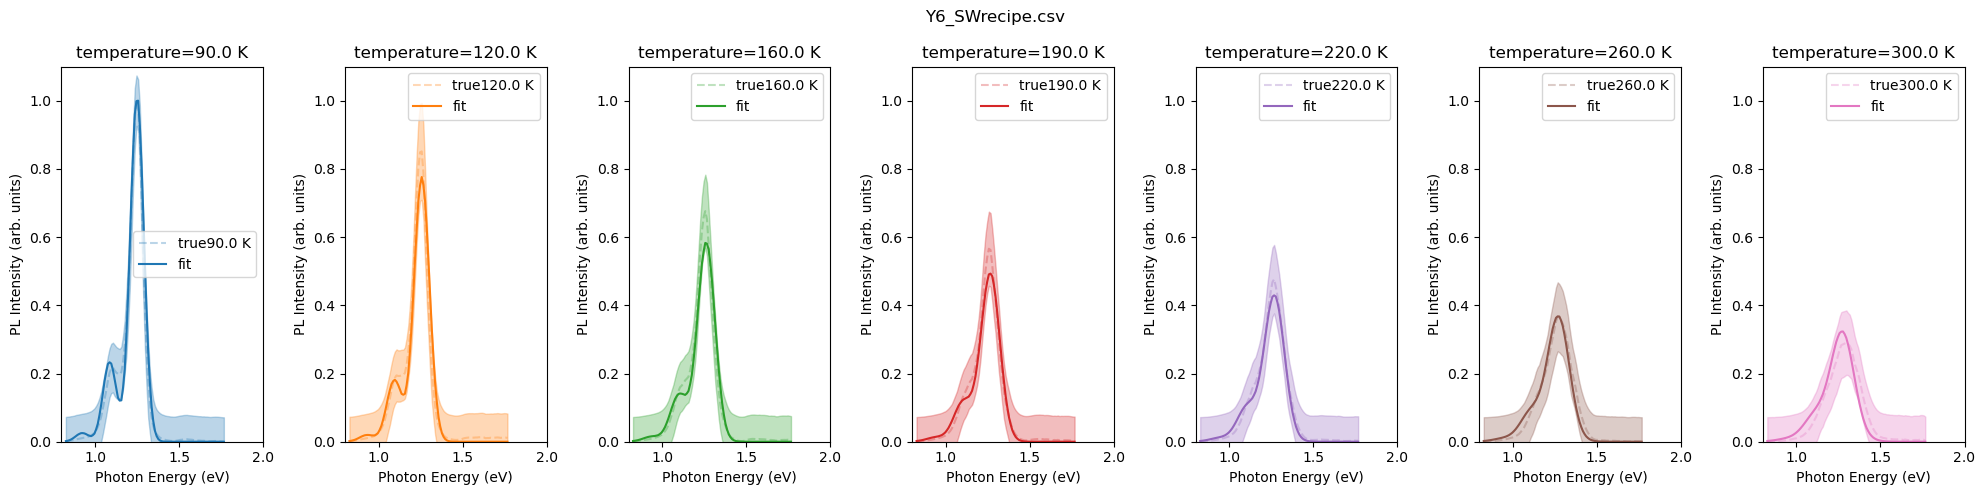

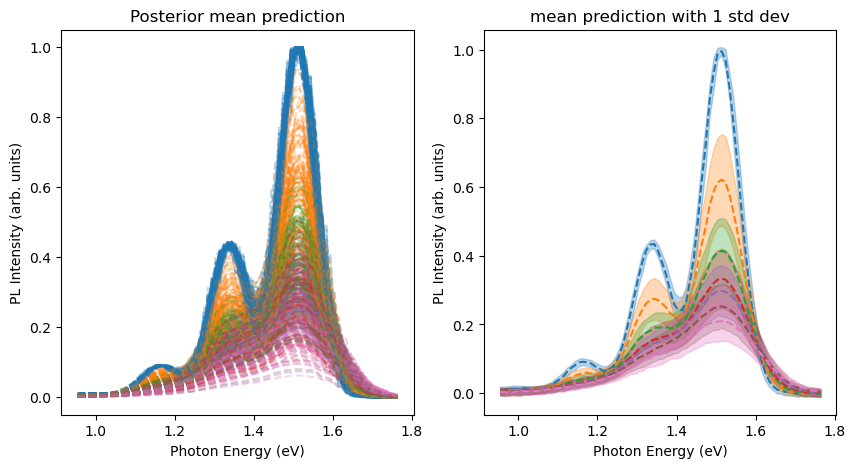

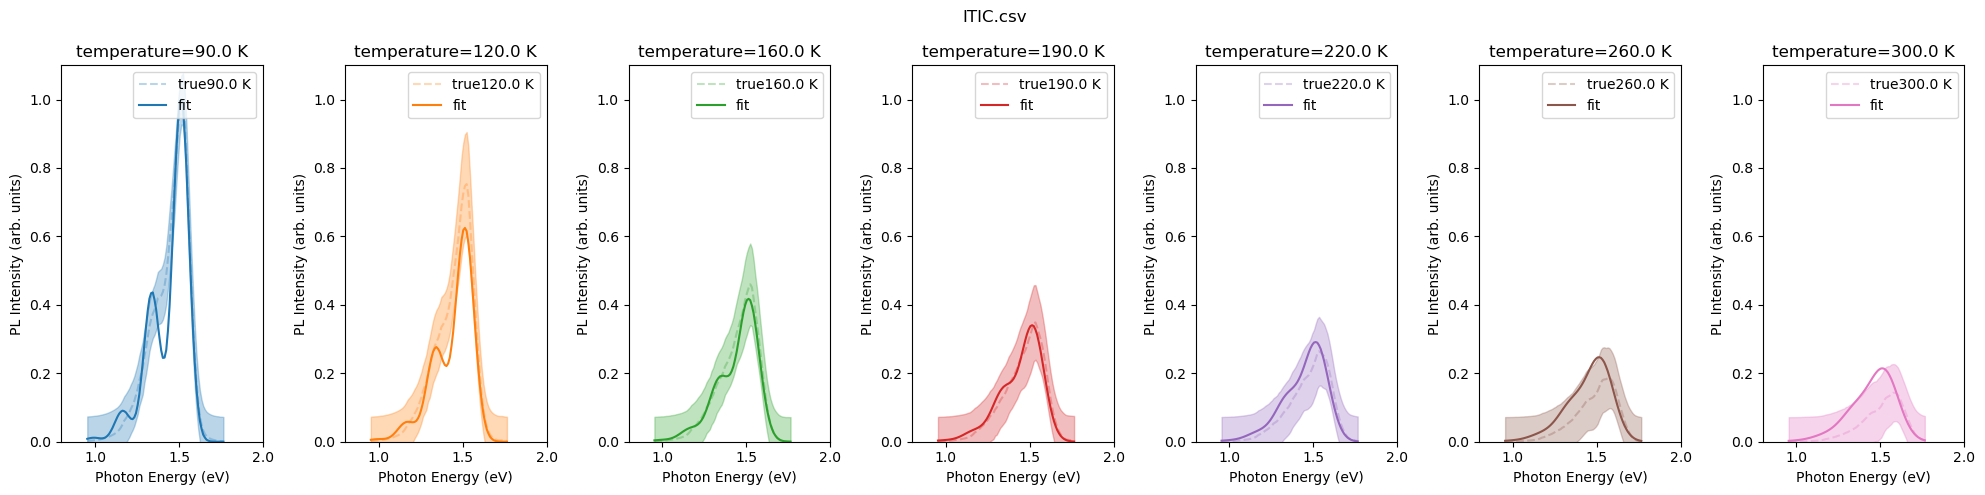

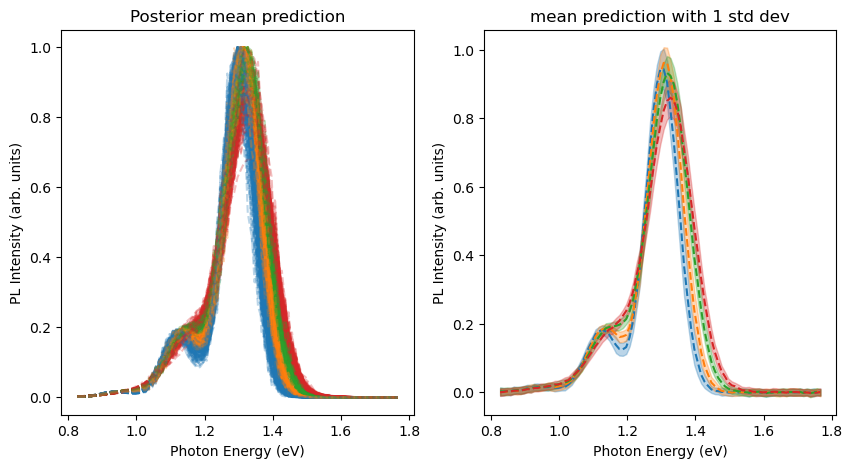

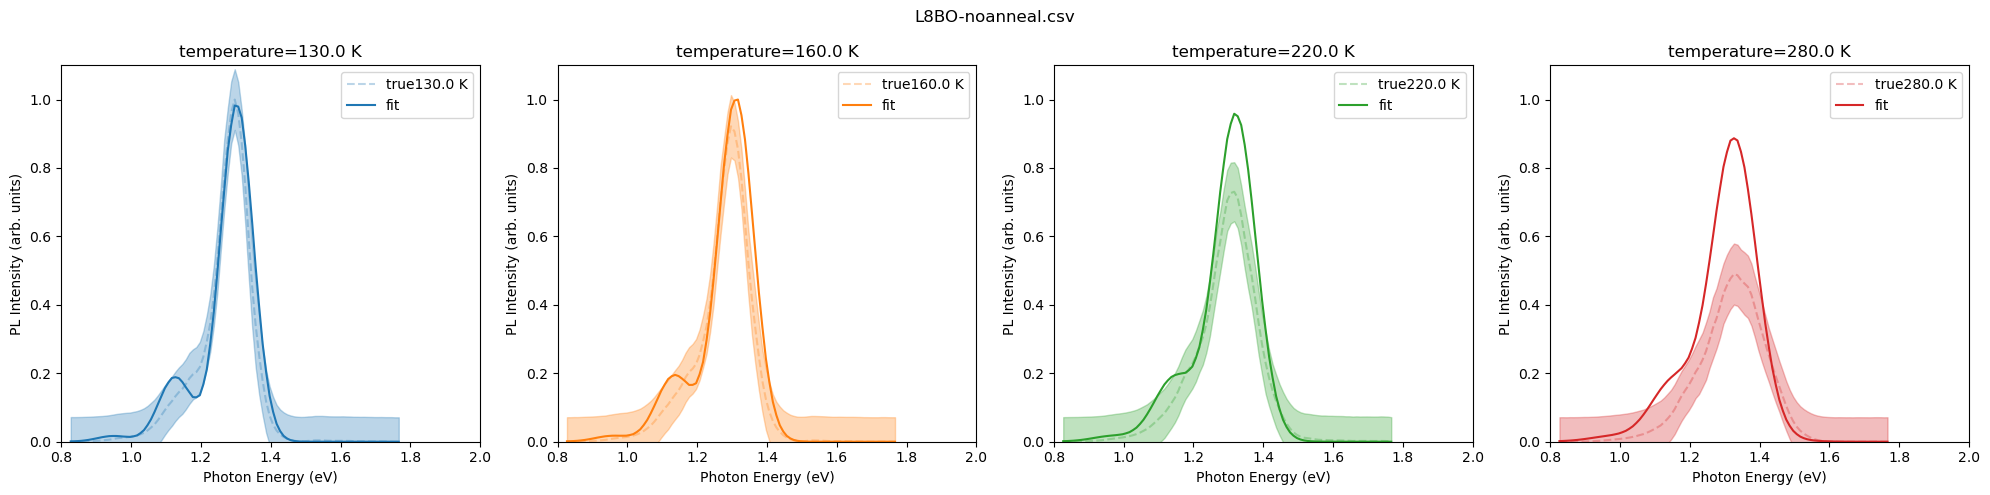

In [165]:
#plot posterior predictive

for index in [0,2,3]:

    filename = df['saved_folder'][index] + "/sampler.h5"
    csv_name = csv_names[df['csv_position'][index]]
    reader = fit_Pl_exp_EMCEE.hDFBackend_2(filename, name="multi_core")
    distribution = reader.get_chain(discard=1, thin=5, flat=True)

    print(csv_name)
    Exp_data, temperature_list, hws = Exp_data_utils.read_data(csv_name)
    true_parameters=list(np.mean(distribution,axis=0))
    truemodel_pl= fit_Pl_exp_EMCEE.pl_trial( true_parameters, temperature_list, hws   ) 
    truemodel_pl = truemodel_pl/np.max(truemodel_pl.reshape(-1,1))
    co_var_mat = fit_Pl_exp_EMCEE.plot_generated_data( temperature_list, hws, save_folder, model_config, savefig=False, true_parameters=true_parameters)
    variance_data = co_var_mat.diagonal().reshape(hws.shape[0],-1).copy()#variance.copy()
    fig,ax = Exp_data_utils.plot_PL_data_with_variance(Exp_data, temperature_list, hws, variance_data, save_folder)
    for i,axes  in enumerate(ax): 
        axes.plot(hws,truemodel_pl[:,i],label='fit',color="C" + str(i) )
        axes.legend()
        axes.set_ylim(0,1.1)
        axes.set_xlim(0.8,2)
    fig.suptitle(csv_name.split('/')[-1])
    fig.tight_layout(h_pad=0.0)

Initial size: 10000
(319936,)


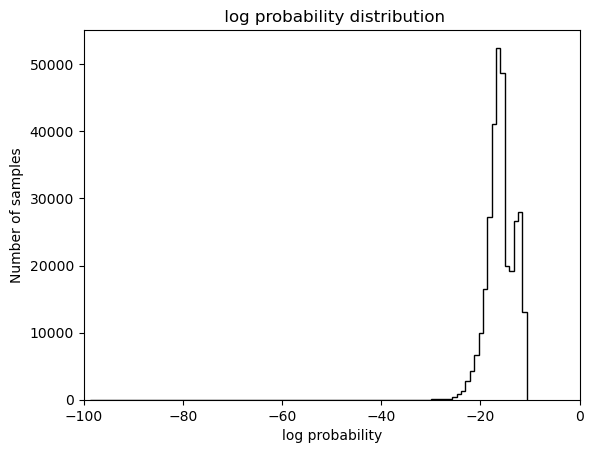

(319936,)
experiemental_data/L8BO-noanneal.csv


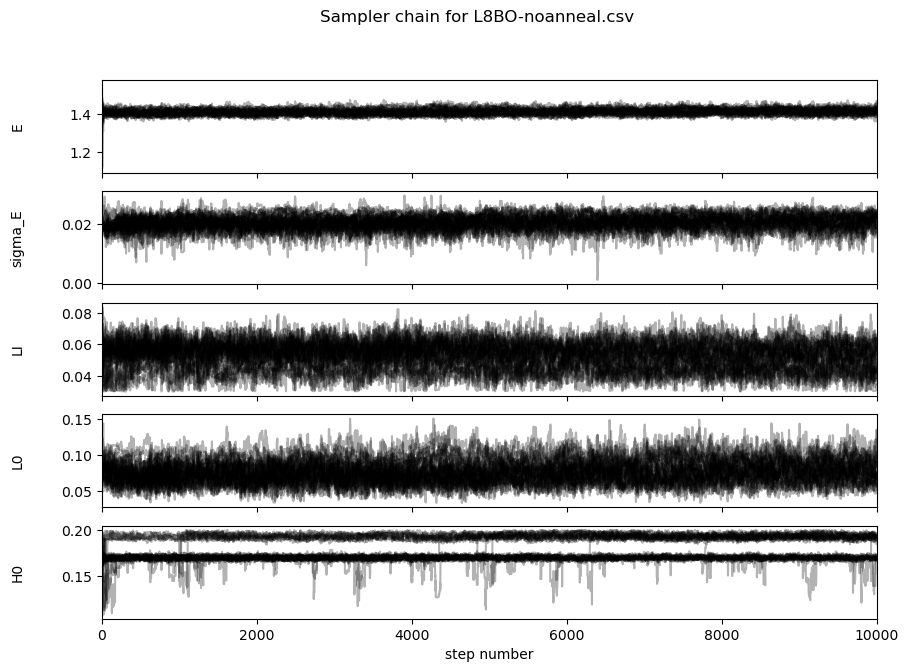

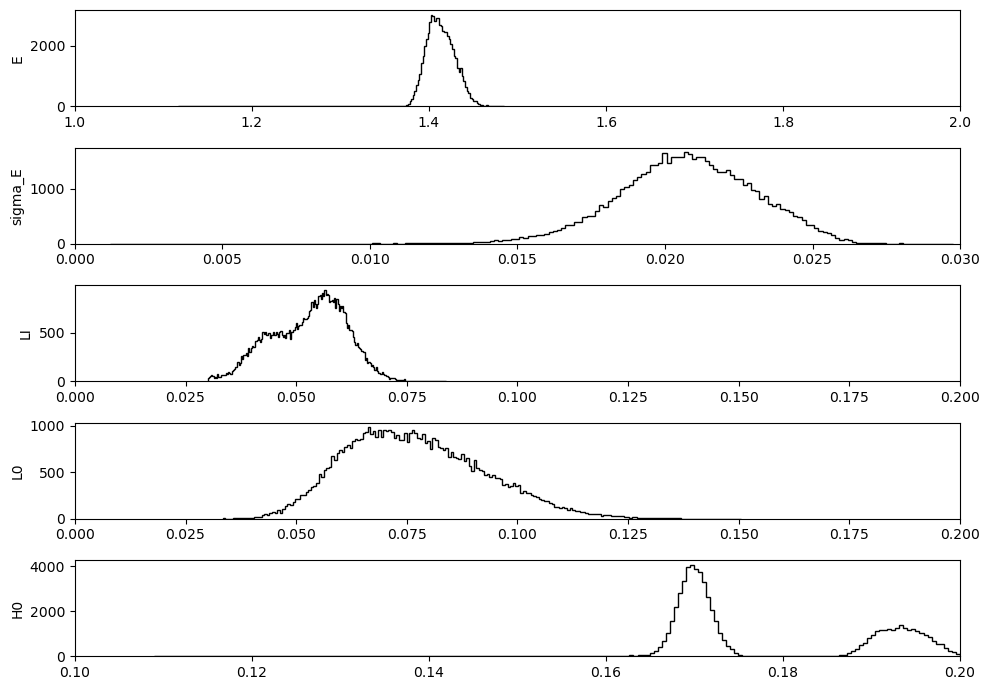

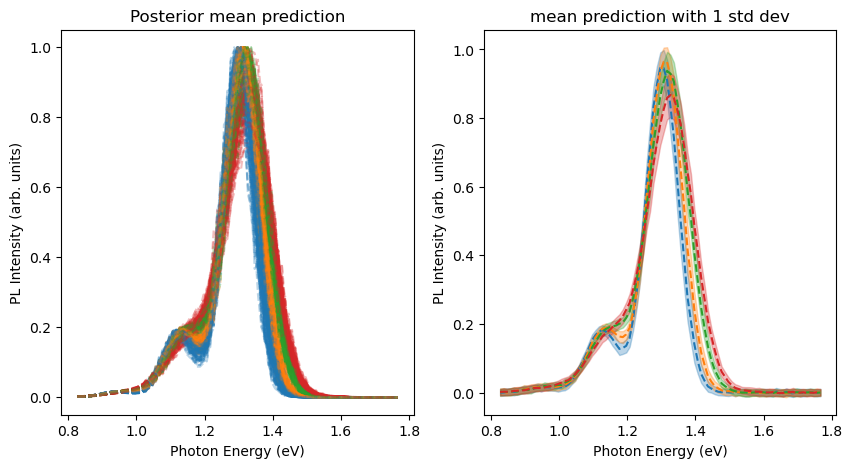

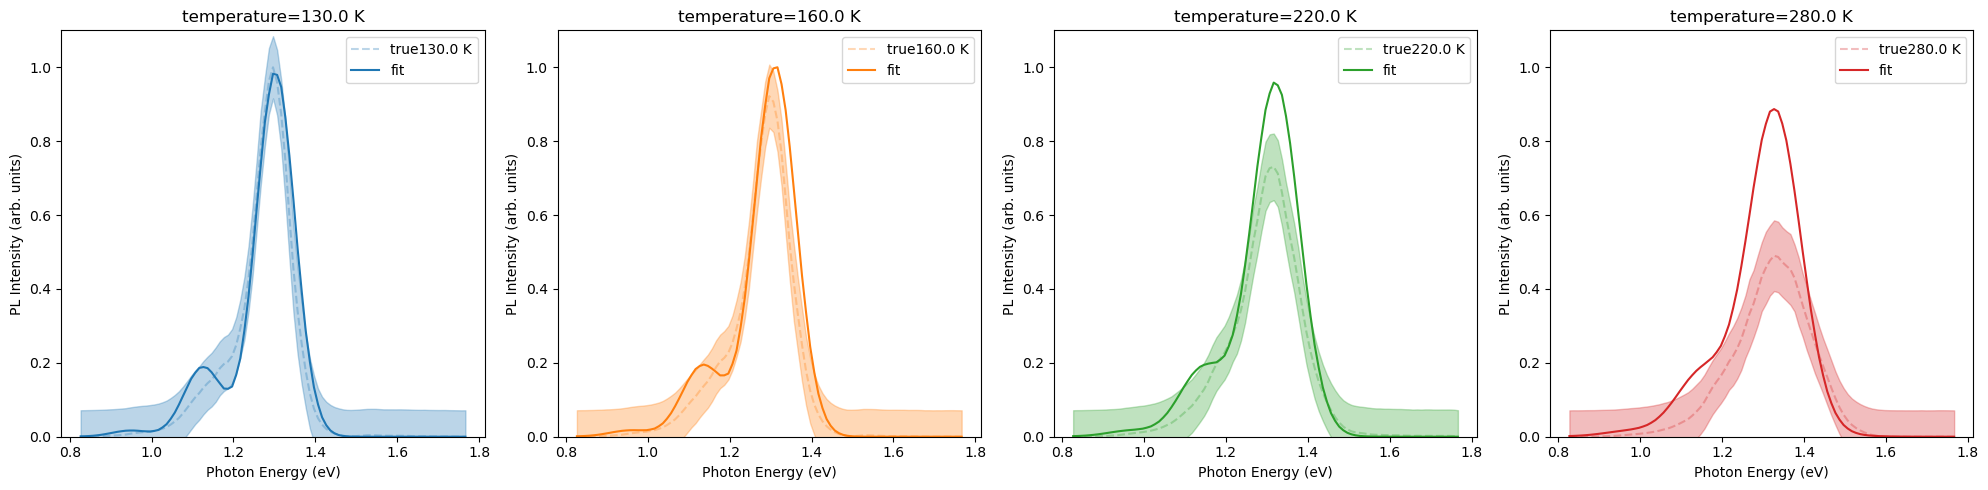

In [169]:
#load data and plot the relevant histograms
index = 3
filename = df['saved_folder'][index] + "/sampler.h5"
csv_name = csv_names[df['csv_position'][index]]
reader = fit_Pl_exp_EMCEE.hDFBackend_2(filename, name="multi_core")
print("Initial size: {0}".format(reader.iteration))
flat_samples = reader.get_log_prob(discard=2, thin=1, flat=True)
print(flat_samples.shape)
plt.hist(flat_samples[flat_samples>-1e2], 100, color="k", histtype="step")
plt.xlabel("log probability")
plt.ylabel("Number of samples")
plt.xlim(-100,0)
plt.title(' log probability distribution')
plt.show()
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = reader.get_chain()
labels = ["E", "sigma_E", "LI", "L0", "H0"]
ndim = len(labels)
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")
fig.suptitle(f"Sampler chain for {csv_name.split('/')[-1]}")
fig.show()
#flat_samples.shape
distribution = reader.get_chain(discard=1, thin=5, flat=True)
true_parameters=list(np.mean(distribution,axis=0))
print(flat_samples.shape)
fig, axes = plt.subplots(5, figsize=(10, 7))
axes_xlim = [[1,2],[0,0.03],[0,0.2],[0,0.2],[0.1,0.2]]
for i in range(ndim):
    ax = axes[i]
    ax.hist(distribution[:, i], 200, color="k", histtype="step")
    #ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.set_xlim(axes_xlim[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)
fig.tight_layout()
fig.show()
# add noise to the data and plot it now with the fitted parameters
#plot posterior predictive
print(csv_name)
Exp_data, temperature_list, hws = Exp_data_utils.read_data(csv_name)
true_parameters=list(np.mean(distribution,axis=0))
truemodel_pl= fit_Pl_exp_EMCEE.pl_trial( true_parameters, temperature_list, hws   ) 
truemodel_pl = truemodel_pl/np.max(truemodel_pl.reshape(-1,1))
co_var_mat = fit_Pl_exp_EMCEE.plot_generated_data( temperature_list, hws, save_folder, model_config, savefig=False, true_parameters=true_parameters)
variance_data = co_var_mat.diagonal().reshape(hws.shape[0],-1).copy()#variance.copy()
fig,ax = Exp_data_utils.plot_PL_data_with_variance(Exp_data, temperature_list, hws, variance_data, save_folder)
for i,axes  in enumerate(ax): 
    axes.plot(hws,truemodel_pl[:,i],label='fit',color="C" + str(i) )
    axes.legend()
    axes.set_ylim(0,1.1)

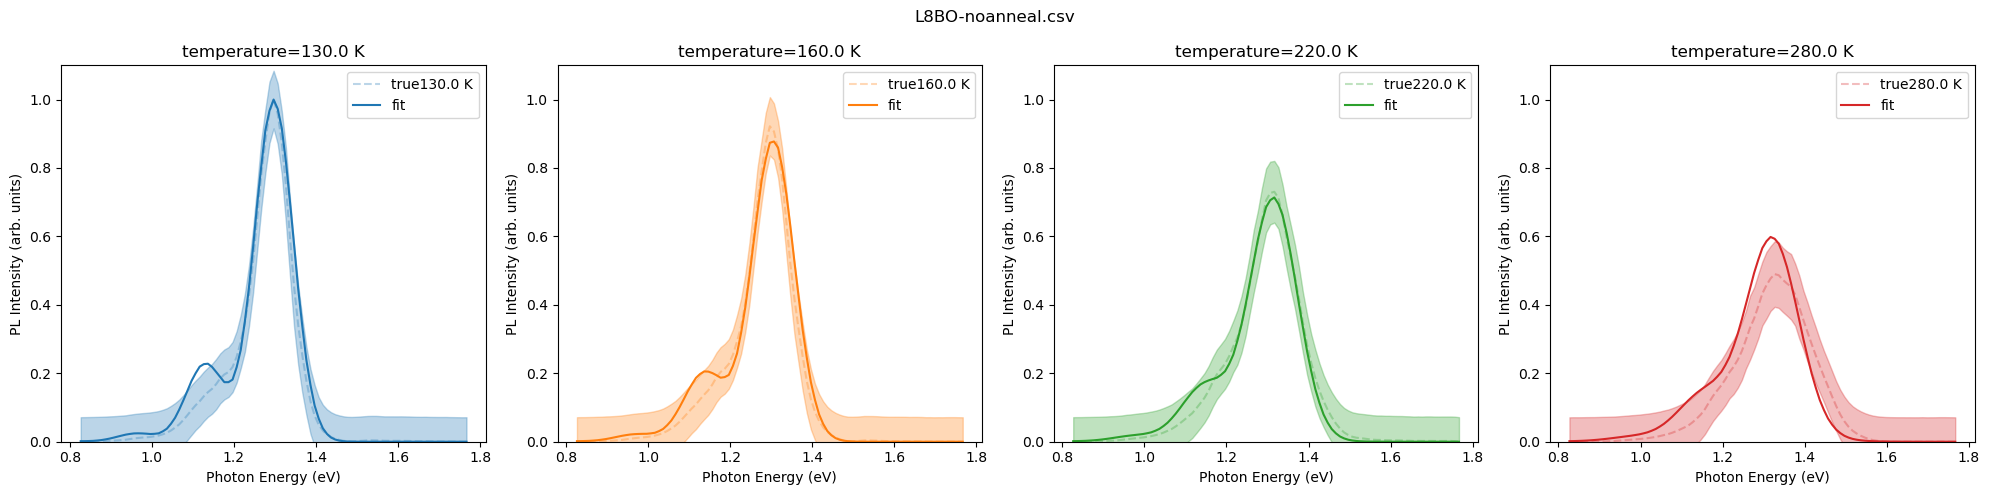

In [189]:
true_parameters = [1.406,0.02,0.058,0.078,0.168]
truemodel_pl= fit_Pl_exp_EMCEE.pl_trial( true_parameters, temperature_list, hws   ) 
truemodel_pl = truemodel_pl/np.max(truemodel_pl.reshape(-1,1))
fig,ax = Exp_data_utils.plot_PL_data_with_variance(Exp_data, temperature_list, hws, variance_data, save_folder)
for i,axes  in enumerate(ax): 
    axes.plot(hws,truemodel_pl[:,i],label='fit',color="C" + str(i) )
    axes.legend()
    axes.set_ylim(0,1.1)
fig.suptitle(csv_name.split('/')[-1])
fig.tight_layout(h_pad=0.0)

In [172]:
tau = reader.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [299.71875327 213.10135106 320.39899386 269.9083632  656.22555437]

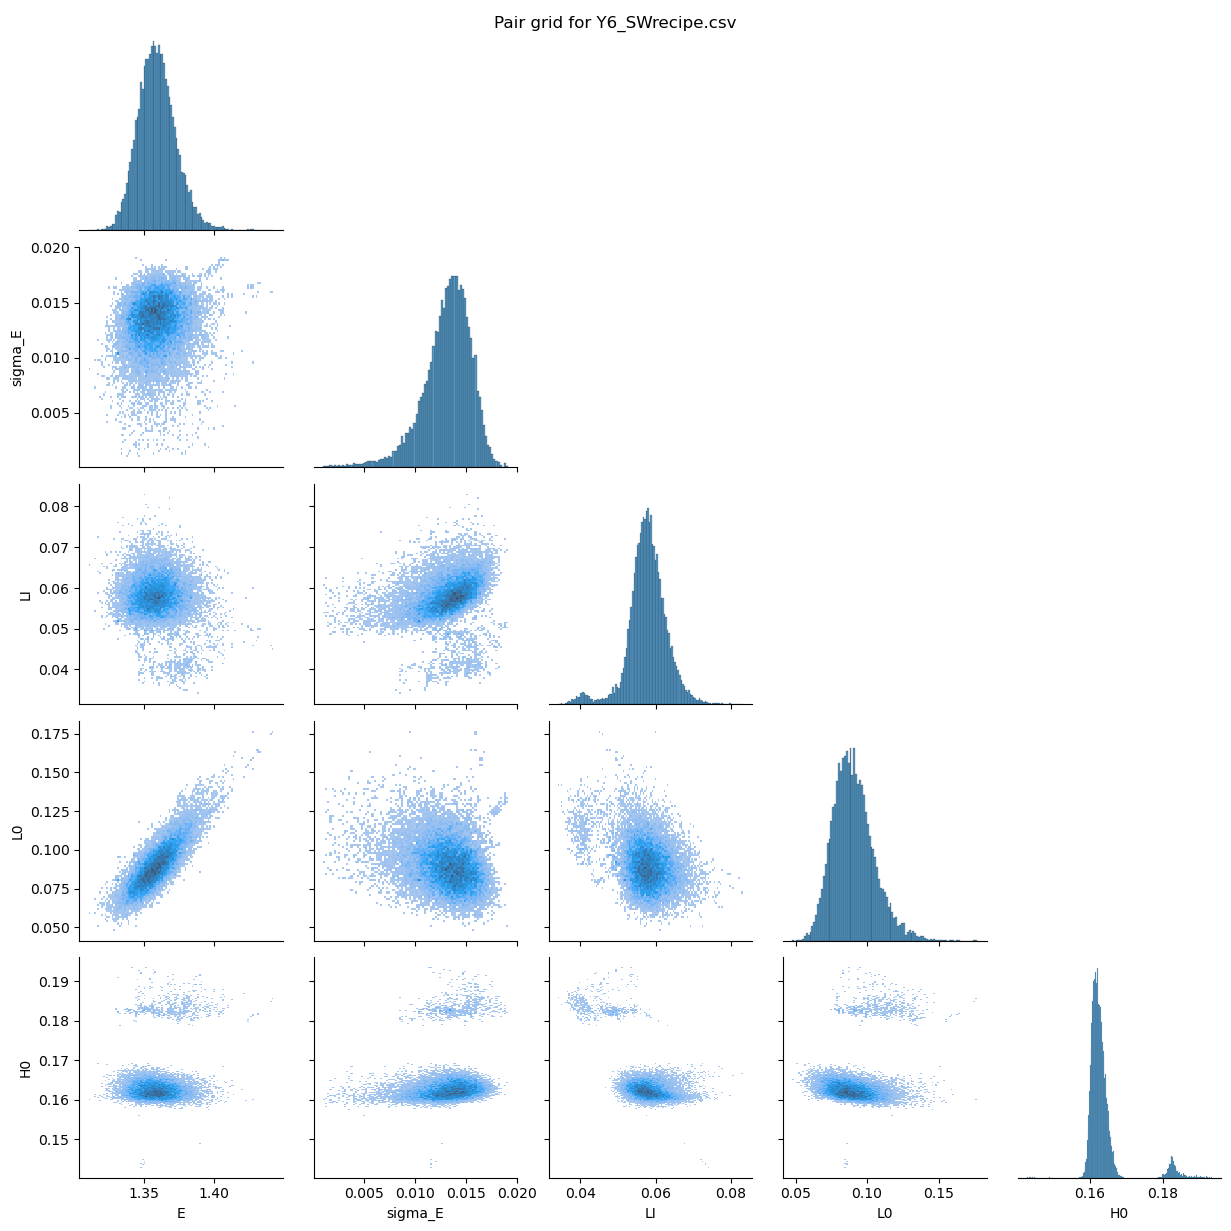

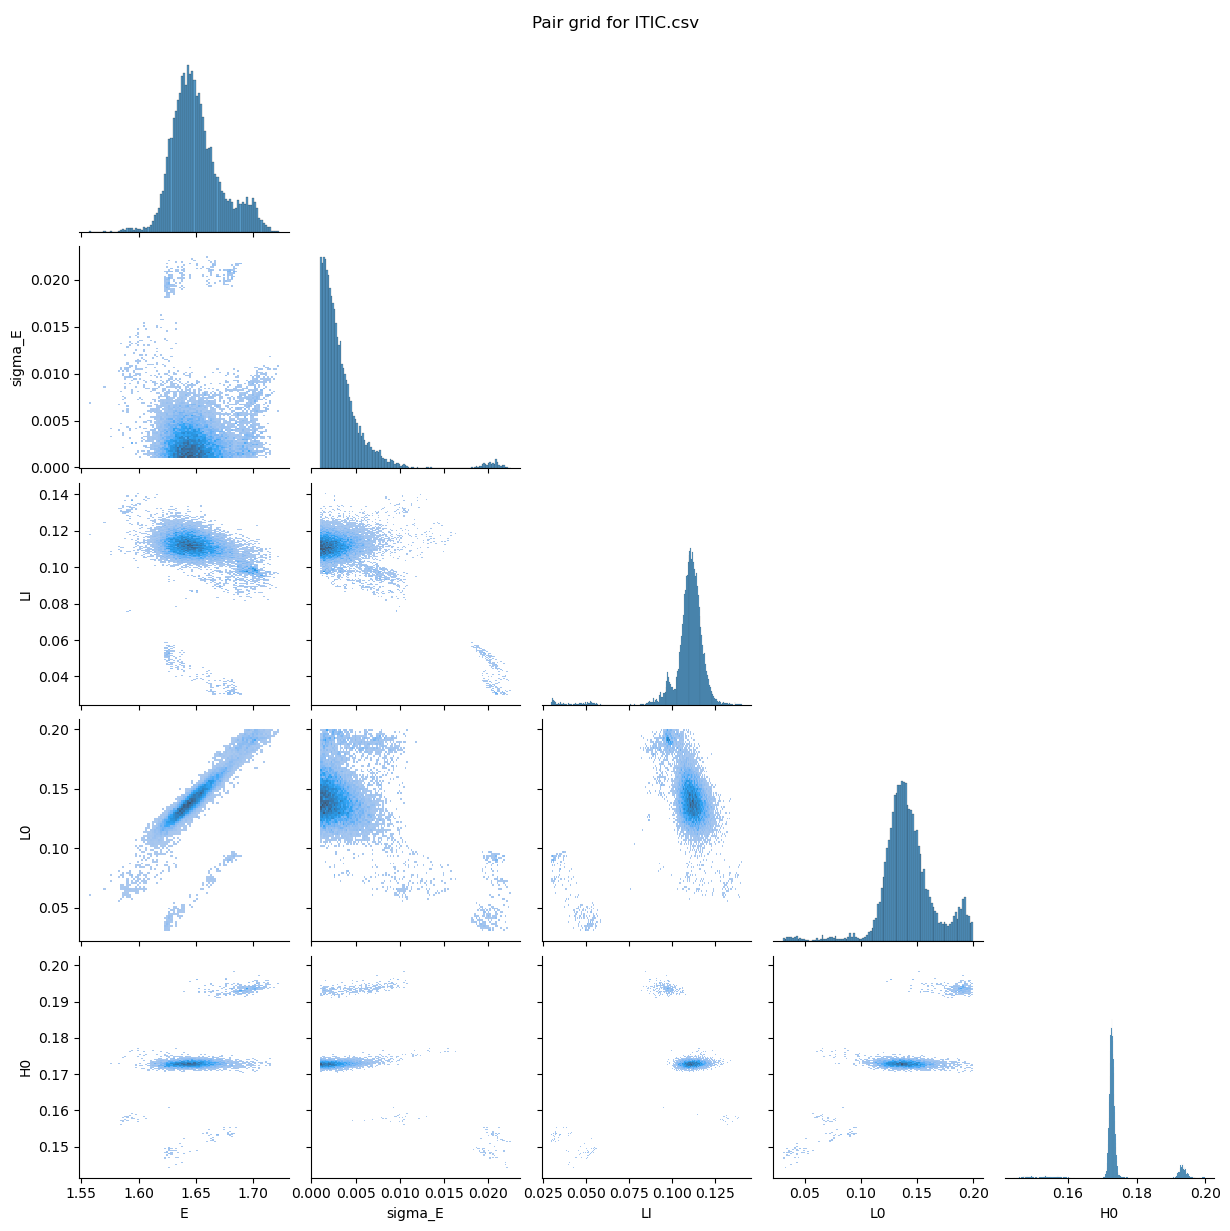

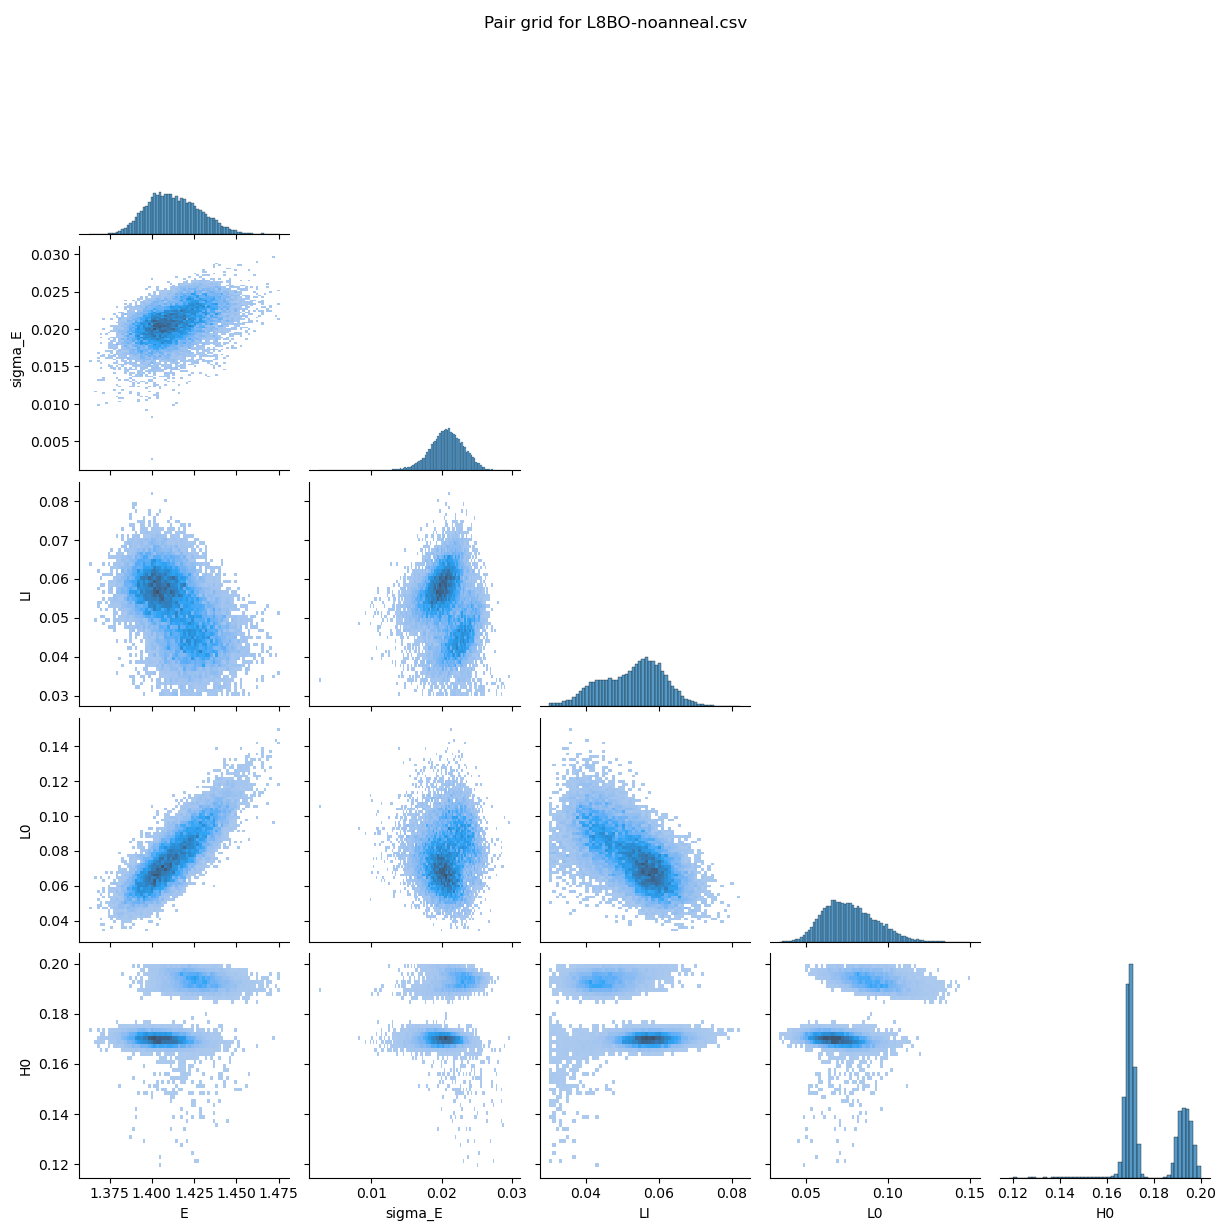

In [194]:
# plot a pair grid plot
import seaborn as sns
#plot posterior predictive

for index in [0,2,3]:

    filename = df['saved_folder'][index] + "/sampler.h5"
    csv_name = csv_names[df['csv_position'][index]]
    reader = fit_Pl_exp_EMCEE.hDFBackend_2(filename, name="multi_core")
    samples = reader.get_chain(discard=100, thin=15, flat=True)
    df_samples = pd.DataFrame(samples, columns=labels)
    g = sns.pairplot(df_samples, kind="hist", corner=True)
    #g = sns.PairGrid(df,diag_sharey=False, corner=True)
    #g.map_lower(sns.scatterplot)
    #g.map_diag(sns.kdeplot)
    g.fig.suptitle(f"Pair grid for {csv_name.split('/')[-1]}")
    g.fig.show()


experiemental_data/Y6_SWrecipe.csv


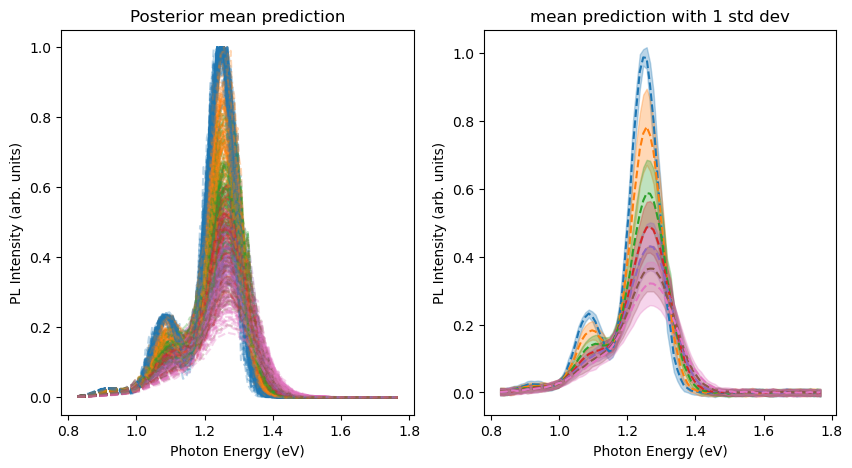

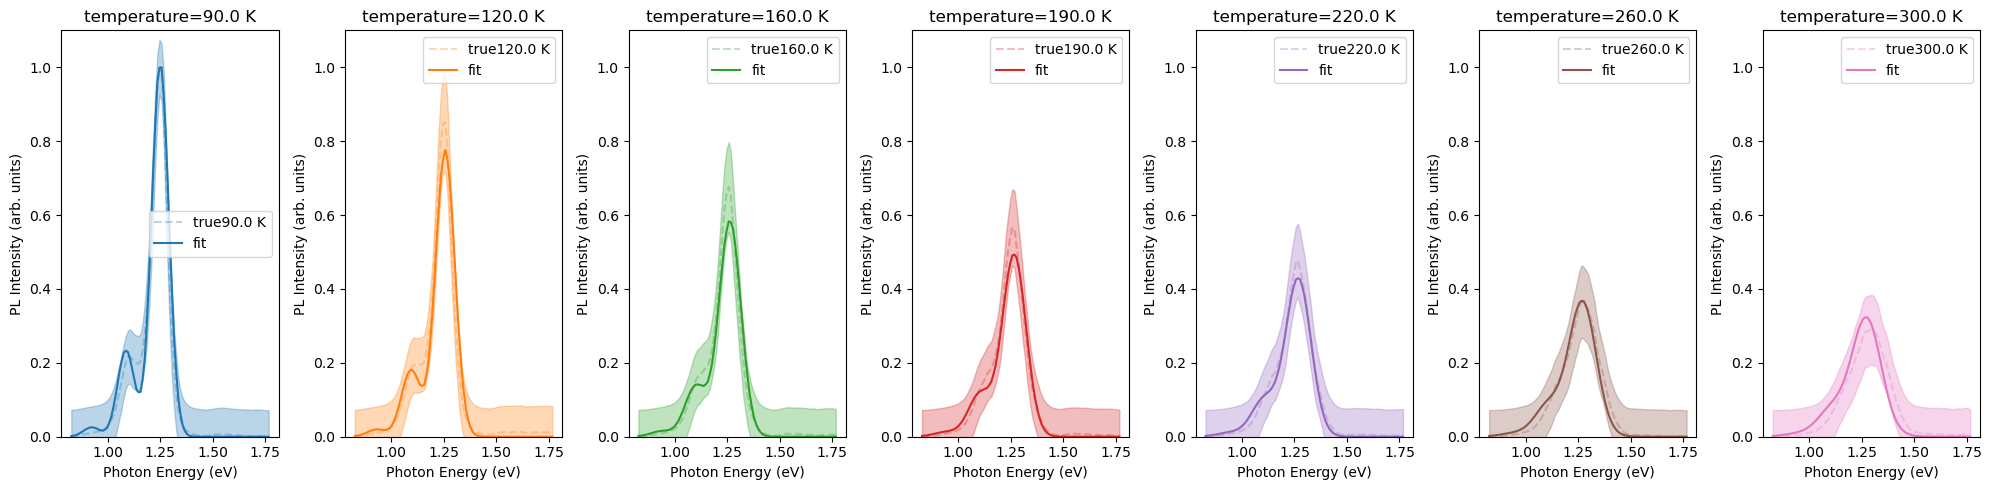

In [140]:
# add noise to the data and plot it now with the fitted parameters
#plot posterior predictive
print(csv_name)
Exp_data, temperature_list, hws = Exp_data_utils.read_data(csv_name)
true_parameters=list(np.mean(distribution,axis=0))
truemodel_pl= fit_Pl_exp_EMCEE.pl_trial( true_parameters, temperature_list, hws   ) 
truemodel_pl = truemodel_pl/np.max(truemodel_pl.reshape(-1,1))
co_var_mat = fit_Pl_exp_EMCEE.plot_generated_data( temperature_list, hws, save_folder, model_config, savefig=False, true_parameters=true_parameters)
variance_data = co_var_mat.diagonal().reshape(hws.shape[0],-1).copy()#variance.copy()
fig,ax = Exp_data_utils.plot_PL_data_with_variance(Exp_data, temperature_list, hws, variance_data, save_folder)
for i,axes  in enumerate(ax): 
    axes.plot(hws,truemodel_pl[:,i],label='fit',color="C" + str(i) )
    axes.legend()
    axes.set_ylim(0,1.1)